In [1]:
## Standard libraries
import os
import math
import numpy as np
from typing import Any
from functools import partial

In [2]:
## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
# import seaborn as sns

/var/folders/fj/7ttqfxt94c5cqdh00xr61t880000gn/T/ipykernel_7128/2704770003.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


<Figure size 640x480 with 0 Axes>

In [3]:
## tqdm for progress bars
from tqdm.auto import tqdm

In [4]:
## To run JAX on TPU in Google Colab, uncomment the two lines below
# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

## JAX
import jax
import jax.numpy as jnp
from jax import random
from flax.core import freeze, unfreeze, FrozenDict
from einops import rearrange, parse_shape
from clu import metrics
from ml_collections import ConfigDict

# Seeding for random operations
main_rng = random.PRNGKey(42)

## Flax (NN in JAX)
import flax
from flax import linen as nn
from flax import struct
from flax.training import train_state, checkpoints
from flax.training import orbax_utils
import orbax.checkpoint
import optax

import tensorflow as tf
from keras.datasets import mnist

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
# DATASET_PATH = "../../data"
# Path to the folder where the pretrained models are saved
# CHECKPOINT_PATH = "../../saved_models/tutorial12_jax"

print("Device:", jax.devices()[0])

Device: TFRT_CPU_0


## Dataset

> We'll be using MNIST in the range $[0,255]$ (won't put them in $[0,1]$ as is usually done).

In [5]:
(X_train, Y_train), (X_val, Y_val) = mnist.load_data()

dst_train = tf.data.Dataset.from_tensor_slices((X_train[...,None]))
dst_val = tf.data.Dataset.from_tensor_slices((X_val[...,None]))

dst_train_rdy = dst_train.shuffle(buffer_size=500, seed=42, reshuffle_each_iteration=True)\
                         .batch(256)\
                         .prefetch(1)
dst_val_rdy = dst_val.batch(512)\
                       .prefetch(1)

## Masked Convolution

They define a module to do the masked convolution, but here's already a mask attribute in Flax's `Conv`. Anyway, we'll mimic as of now:

In [6]:
class MaskedConvolution(nn.Module):
    features: int
    mask: jnp.array
    dilation: int = 1

    @nn.compact
    def __call__(self,
                 inputs,
                 **kwargs,
                 ):
        if len(self.mask.shape) == 2:
            mask_ext = self.mask[...,None,None]
            mask_ext = jnp.tile(mask_ext, reps=(1,1,inputs.shape[-1], self.features))
        else:
            mask_ext = self.mask
        
        outputs = nn.Conv(features=self.features, kernel_size=self.mask.shape[:2], kernel_dilation=self.dilation, mask=mask_ext)(inputs)
        return outputs

### Vertical & Horizontal Convolution

In [7]:
ks = 5
mask = jnp.ones(shape=(ks, ks), dtype=jnp.float32)
mask = mask.at[ks//2+1:].set(0)
mask = mask.at[ks//2].set(0)
mask

Array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

In [8]:
class VerticalStackConvolution(nn.Module):
    features: int
    kernel_size: int
    mask_center: bool = False
    dilation: int = 1

    def setup(self):
        mask = jnp.ones(shape=(self.kernel_size, self.kernel_size), dtype=jnp.float32)
        mask = mask.at[self.kernel_size//2+1:].set(0)
        if self.mask_center:
            mask = mask.at[self.kernel_size//2].set(0)
        self.conv = MaskedConvolution(features=self.features, mask=mask, dilation=self.dilation)

    def __call__(self, inputs):
        return self.conv(inputs)

In [9]:
class HorizontalStackConvolution(nn.Module):
    features: int
    kernel_size: int
    mask_center: bool = False
    dilation: int = 1

    def setup(self):
        ## First dim is 1 because we only look for pixels in the same row
        mask = jnp.ones(shape=(1, self.kernel_size), dtype=jnp.float32)
        mask = mask.at[0,self.kernel_size//2+1:].set(0)
        if self.mask_center:
            mask = mask.at[0,self.kernel_size//2].set(0)
        self.conv = MaskedConvolution(features=self.features, mask=mask, dilation=self.dilation)

    def __call__(self, inputs):
        return self.conv(inputs)

## Visualizing the receptive field

In [10]:
def show_center_recep_field(img, apply_fn):
    """Calcualates the gradients of the input with respect to the output center pixel."""

    b, h, w, c = img.shape
    ## 1. Determine gradients
    grad_fn = jax.grad(lambda inp: apply_fn(inp)[0,h//2,w//2].sum()) # Here we're using L1 loss for simplicity
    img_grads = jnp.abs(grad_fn(img))
    img_grads = jax.device_get(img_grads)

    ## 2. Plot receptive field
    img = img_grads[0,...,0]
    fig, axes = plt.subplots(1,2)
    pos = axes[0].imshow(img)
    axes[1].imshow(img>0)

    ## 2.1 Mark the center pixel in red if it doesn't have any gradients
    ## (should be the case for autorregresive models)
    show_center = (img[img.shape[0]//2, img.shape[1]//2] == 0)
    if show_center:
        center_pixel = jnp.zeros(img.shape + (4,))
        center_pixel = center_pixel.at[center_pixel.shape[0]//2, center_pixel.shape[1]].set(jnp.array([1., 0., 0., 1.]))
    for i in range(2):
        axes[i].axis("off")
        if show_center:
            axes[i].imshow(center_pixel)
    axes[0].set_title("Weighted receptive field")
    axes[1].set_title("Binary receptive field")
    plt.show()
    plt.close()

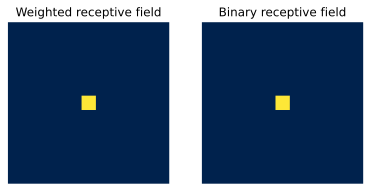

In [11]:
inp_img = jnp.zeros(shape=(1,11,11,1), dtype=jnp.float32)
show_center_recep_field(inp_img, lambda x: x)

### Horizontal

> For simplicity, initialize all the weights to 1 and the bias to 0.

In [12]:
def init_params(path, x):
    if "bias" in path:
        return x*0
    elif "kernel" in path:
        return x/x

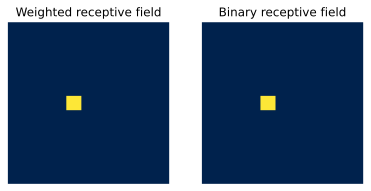

In [13]:
horiz_conv = HorizontalStackConvolution(features=1, kernel_size=3, mask_center=True)
variables = horiz_conv.init(random.PRNGKey(42), inp_img)
variables = flax.traverse_util.path_aware_map(lambda path, x: init_params(path, x), variables)
horiz_conv = horiz_conv.bind(variables)
show_center_recep_field(inp_img, lambda inp: horiz_conv(inp))

### Vertical

> For simplicity, initialize all the weights to 1 and the bias to 0.

In [14]:
def init_params(path, x):
    if "bias" in path:
        return x*0
    elif "kernel" in path:
        return x/x

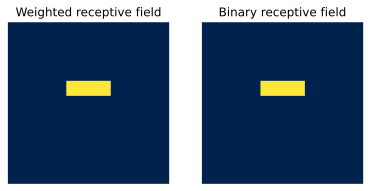

In [15]:
vert_conv = VerticalStackConvolution(features=1, kernel_size=3, mask_center=True)
variables = vert_conv.init(random.PRNGKey(42), inp_img)
variables = flax.traverse_util.path_aware_map(lambda path, x: init_params(path, x), variables)
vert_conv = vert_conv.bind(variables)
show_center_recep_field(inp_img, lambda inp: vert_conv(inp))

### Combination

> For simplicity, initialize all the weights to 1 and the bias to 0.

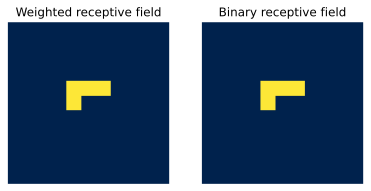

In [16]:
show_center_recep_field(inp_img, lambda inp: horiz_conv(inp) + vert_conv(inp))

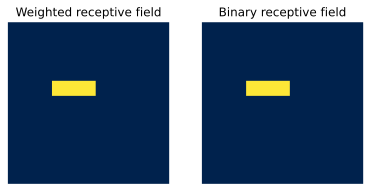

In [17]:
show_center_recep_field(inp_img, lambda inp: vert_conv(horiz_conv(inp)))

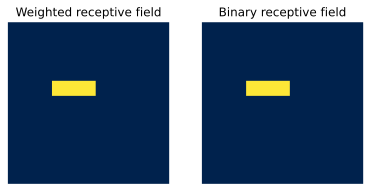

In [18]:
show_center_recep_field(inp_img, lambda inp: horiz_conv(vert_conv(inp)))

### Stacking layers

Things to consider:

1. Center should only be masked for the first convolution. The ones after must have the central pixel unmasked.
2. The vertical convolution cannot be applied to the output of the horizontal convolution because it would mix information from the true pixel.

Because of 2, we are going to have two information streams: one for the vertical stack and one for the horizontal stack, with the vertical only taking vertical outputs as inputs. Now we'll do a very naive implementation only to represent the receptive fields.

In [19]:
horiz_noc_conv = HorizontalStackConvolution(features=1, kernel_size=3, mask_center=False)
variables = horiz_noc_conv.init(random.PRNGKey(42), inp_img)
variables = flax.traverse_util.path_aware_map(lambda path, x: init_params(path, x), variables)
horiz_noc_conv = horiz_noc_conv.bind(variables)

In [20]:
vert_noc_conv = VerticalStackConvolution(features=1, kernel_size=3, mask_center=False)
variables = vert_noc_conv.init(random.PRNGKey(42), inp_img)
variables = flax.traverse_util.path_aware_map(lambda path, x: init_params(path, x), variables)
vert_noc_conv = vert_noc_conv.bind(variables)

In [21]:
def num_layer_network(inp, num_layers):
    vert_img = vert_conv(inp)
    horiz_img = horiz_conv(inp) + vert_img
    for _ in range(num_layers-1):
        vert_img = vert_noc_conv(vert_img)
        horiz_img = horiz_noc_conv(horiz_img) + vert_img
    return horiz_img, vert_img

Layer 2


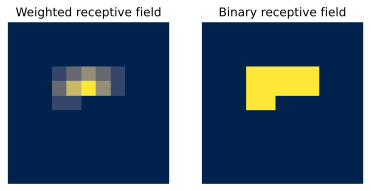

Layer 3


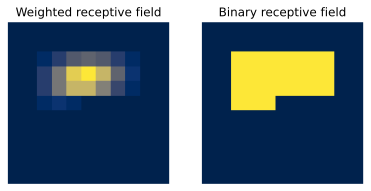

Layer 4


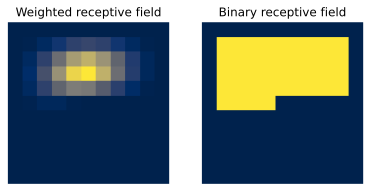

Layer 5


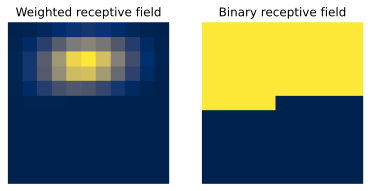

In [22]:
for layer_count in range(2,6):
    print(f"Layer {layer_count}")
    show_center_recep_field(inp_img, lambda inp: num_layer_network(inp, layer_count)[0])

## Gated PixelCNN

The difference between the Gated and the original version is the use of the two different information streams (vertical & horizontal).
To visualize the receptive fields as before, we took a very naive approach to how the information of the different streams is mixed. No we are going to use gated convolutions to mix this information in a more sophisticated way. The main motivation is that it might allow to model more complex interactions and simplifies the learning.

The horizontal stream uses a skip connection while the vertical does not. This is because we use the horizontal stack for the prediction. The vertical stack is only 2 1x1 convolutions away from the residual stream and thus receives a good gradient.

https://arxiv.org/pdf/1606.05328

In [23]:
class GatedMaskedConv(nn.Module):
    dilation: int = 1

    @nn.compact
    def __call__(self, v_stack, h_stack):
        c_in = v_stack.shape[-1]

        conv_vert = VerticalStackConvolution(features=2*c_in,
                                             kernel_size=3,
                                             mask_center=False,
                                             dilation=self.dilation)
        conv_horiz = HorizontalStackConvolution(features=2*c_in,
                                                kernel_size=3,
                                                mask_center=False,
                                                dilation=self.dilation)
        conv_vert_to_horiz = nn.Conv(features=2*c_in,
                                     kernel_size=(1,1))
        conv_horiz_1x1 = nn.Conv(features=c_in,
                                 kernel_size=(1,1))

        ## Vertical stack
        v_stack_feat = conv_vert(v_stack)
        # v_val, v_gate = v_stack_feat.split(2, axis=-1)
        v_val, v_gate = jnp.split(v_stack_feat, 2, axis=-1)
        v_stack_out = nn.tanh(v_val) * nn.sigmoid(v_gate)

        ## Horizontal stack
        h_stack_feat = conv_horiz(h_stack)
        h_stack_feat = h_stack_feat + conv_vert_to_horiz(v_stack_feat)
        # h_val, h_gate = h_stack_feat.split(2, axis=-1)
        h_val, h_gate = jnp.split(h_stack_feat, 2, axis=-1)
        h_stack_out = nn.tanh(h_val) * nn.sigmoid(h_gate)
        h_stack_out = conv_horiz_1x1(h_stack_out)
        h_stack_out = h_stack_out + h_stack

        return v_stack_out, h_stack_out

## Building the model

The model consists of multiple stacked `GatedMaskedConv` blocks where we add an additional dilation factor to a few convolutions. Instead of using dilated convolutions we could use an encoder-decoder architecture as in PixelCNN++. This would be better to build a very deep model, but we have more than enough.

In [24]:
class PixelCNN(nn.Module):
    c_in: int
    c_hidden: int

    def setup(self):
        ## Initial convolutions skipping the center pixel
        self.conv_vstack = VerticalStackConvolution(self.c_hidden, kernel_size=3, mask_center=True)
        self.conv_hstack = HorizontalStackConvolution(self.c_hidden, kernel_size=3, mask_center=True)

        ## Gated convolution blocks. We use dilation instead of downsampling
        self.conv_layers = [
            GatedMaskedConv(),
            GatedMaskedConv(dilation=2),
            GatedMaskedConv(),
            GatedMaskedConv(dilation=4),
            GatedMaskedConv(),
            GatedMaskedConv(dilation=2),
            GatedMaskedConv(),
        ]

        ## Output classification convolution. We have to predict a probability for each possible pixel value.
        self.conv_out = nn.Conv(self.c_in*256, kernel_size=(1,1))

    def pred_logits(self, inputs):
        ## 1. Scale input from [0,255] to [-1,1]
        inputs = (inputs.astype(jnp.float32) / 255.0)*2 - 1

        ## 2. Initial convolutions
        v_stack = self.conv_vstack(inputs)
        h_stack = self.conv_hstack(inputs)

        ## 3. Gated convolutions (This can probably be a `scan`)
        for layer in self.conv_layers:
            v_stack, h_stack = layer(v_stack, h_stack)

        ## 4. 1x1 classification convolution
        outputs = self.conv_out(nn.elu(h_stack))

        ## 5. Put into proper shape
        outputs = rearrange(outputs, "b h w (c_in cls) -> b h w c_in cls", **parse_shape(inputs, "b h w c_in"))

        return outputs

    def __call__(self, inputs):
        """Forward pass with bpd calculation."""
        logits = self.pred_logits(inputs)
        labels = inputs.astype(jnp.int32)
        nll = optax.softmax_cross_entropy_with_integer_labels(logits, labels)
        bpd = nll.mean() + np.log2(np.exp(1))
        return bpd

    def sample(self, img_shape, rng, img=None):
        ## 1. Create empty image
        if img is None:
            img = jnp.zeros(shape=img_shape, dtype=jnp.int32) - 1

        ## 2. Generation loop
        get_logits = jax.jit(lambda inp: self.pred_logits(inp))
        for h in tqdm(range(img_shape[1]), leave=False):
            for w in tqdm(range(img_shape[2])):
                for c in tqdm(range(img_shape[3])):
                    ## 2.1. Skip if not to be filled (-1)
                    if (img[:,h,w,c] != -1).all().item():
                        continue
                    logits = get_logits(img)
                    logits = logits[:,h,w,c,:]
                    rng, pix_rng = random.split(rng)
                    img = img.at[:,h,w,c].set(random.categorical(pix_rng, logits, axis=-1))
        return img

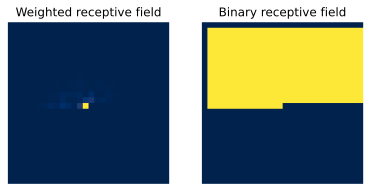

In [25]:
model = PixelCNN(c_in=1, c_hidden=64)
inp = jnp.zeros(shape=(1,28,28,1))
variables = model.init(random.PRNGKey(42), inp)
show_center_recep_field(inp, lambda x: model.bind(variables).pred_logits(x)[...,0,0])

## Training Loop

In [26]:
@struct.dataclass
class Metrics(metrics.Collection):
    """Collection of metrics to be tracked during training."""
    loss: metrics.Average.from_output("loss")

In [27]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    state: FrozenDict

In [28]:
def create_train_state(module, key, tx, input_shape):
    """Creates the initial `TrainState`."""
    variables = module.init(key, jnp.ones(input_shape))
    state, params = variables.pop('params')
    return TrainState.create(
        apply_fn=module.apply,
        params=params,
        state=state,
        tx=tx,
        metrics=Metrics.empty()
    )

In [29]:
@partial(jax.jit, static_argnums=2)
def train_step(state, batch, return_grads=False):
    """Train for a single step."""
    img = batch
    def loss_fn(params):
        ## Forward pass through the model
        loss = state.apply_fn({"params": params, **state.state}, img)
        return loss
    
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    metrics_updates = state.metrics.single_from_model_output(loss=loss)
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    if return_grads: return state, grads
    else: return state

In [30]:
@jax.jit
def compute_metrics(*, state, batch):
    img = batch
    def loss_fn(params):
        ## Forward pass through the model
        loss = state.apply_fn({"params": params, **state.state}, img)
        return loss
    
    metrics_updates = state.metrics.single_from_model_output(loss=loss_fn(state.params))
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    return state

In [31]:
config = ConfigDict({
    "EPOCHS": 20,
    "SEED": 42,
    "LEARNING_RATE": 3e-4,
    "C_IN": 1,
    "C_HIDDEN": 64, 
})

In [32]:
state = create_train_state(PixelCNN(c_in=config.C_IN, c_hidden=config.C_HIDDEN), random.PRNGKey(config.SEED), optax.adam(config.LEARNING_RATE), input_shape=(1,28,28,1))

In [33]:
param_count = sum(x.size for x in jax.tree_util.tree_leaves(state.params))
param_count

852160

In [34]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(state)

In [35]:
metrics_history = {
    "train_loss": [],
    "val_loss": [],
}

In [36]:
batch = next(iter(dst_train_rdy.as_numpy_iterator()))

In [37]:
%%time
s1, grads = train_step(state, batch, return_grads=True)

In [ ]:
%%time
s1 = compute_metrics(state=state, batch=batch)

CPU times: user 9.58 s, sys: 311 ms, total: 9.89 s
Wall time: 2.65 s


In [ ]:
%%time
for epoch in range(config.EPOCHS):
    ## Training
    for batch in dst_train_rdy.as_numpy_iterator():
        state, grads = train_step(state, batch, return_grads=True)
        # wandb.log({f"{k}_grad": wandb.Histogram(v) for k, v in flatten_params(grads).items()}, commit=False)
        # state = compute_metrics(state=state, batch=batch)
        # break

    ## Log the metrics
    for name, value in state.metrics.compute().items():
        metrics_history[f"train_{name}"].append(value)
    
    ## Empty the metrics
    state = state.replace(metrics=state.metrics.empty())

    ## Evaluation
    for batch in dst_val_rdy.as_numpy_iterator():
        state = compute_metrics(state=state, batch=batch)
        # break
    for name, value in state.metrics.compute().items():
        metrics_history[f"val_{name}"].append(value)
    state = state.replace(metrics=state.metrics.empty())
    
    ## Obtain activations of last validation batch
    # _, extra = forward_intermediates(state, batch[0])
    
    ## Checkpointing
    if metrics_history["val_loss"][-1] <= min(metrics_history["val_loss"]):
        # orbax_checkpointer.save(os.path.join(wandb.run.dir, "model-best"), state, save_args=save_args, force=True) # force=True means allow overwritting.
        orbax_checkpointer.save("model-best", state, save_args=save_args, force=True) # force=True means allow overwritting.
    # orbax_checkpointer.save(os.path.join(wandb.run.dir, f"model-{epoch+1}"), state, save_args=save_args, force=False) # force=True means allow overwritting.

    # wandb.log({f"{k}": wandb.Histogram(v) for k, v in flatten_params(state.params).items()}, commit=False)
    # wandb.log({f"{k}": wandb.Histogram(v) for k, v in flatten_params(extra["intermediates"]).items()}, commit=False)
    # wandb.log({"epoch": epoch+1, **{name:values[-1] for name, values in metrics_history.items()}})
    print(f'Epoch {epoch} -> [Train] Loss: {metrics_history["train_loss"][-1]} [Val] Loss: {metrics_history["val_loss"][-1]}')
    # break

KeyboardInterrupt: 